In [7]:
import os
def dataset_from_text_file(file_names):
    if isinstance(file_names, str):
        file_names = [file_names]
    for file_name in file_names:
        with open(file_name, 'r') as f:
            text = f.read()
        print(text)
    return None
data_dir = '../docs/interviews'
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
with open(files[0], 'r') as f:
    text = f.read()
# kapitza = dataset_from_text_file(file_names=files)

In [6]:
# !pip install langchain spacy
# !python -m spacy download en_core_web_sm
from langchain.text_splitter import SpacyTextSplitter
text_splitter = SpacyTextSplitter(chunk_size=256, chunk_overlap=256//4)

In [8]:
# functions to train and test
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
base_model, tokenizer = FastLanguageModel.from_pretrained( model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit", # "model",
    max_seq_length = 8192, dtype = None, load_in_4bit = True)
tokenizer = get_chat_template(tokenizer, chat_template = "llama-3", 
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
)
FastLanguageModel.for_inference(base_model) 

def ask_llm(prompt, user, n_rep=1):
    inputs = tokenizer.apply_chat_template( [{"system": prompt,\
                                          "from": "human", \
                                          "value": user}],
    tokenize = True, add_generation_prompt = True, return_tensors = "pt").to(base_model.device)
    questions = []
    for _ in range(n_rep):
        outputs = base_model.generate(input_ids = inputs, max_new_tokens = 128, use_cache = True)
        full_output = tokenizer.batch_decode(outputs)
        answer = full_output[0].split('|end_header_id|>\n\n')[-1].rstrip('<|eot_id|>')
        questions.append(answer)
    
    return questions[0] if len(questions) == 1 else questions

/home/zipa/miniconda3/envs/unsloth_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.9.post3: Fast Llama patching. Transformers = 4.45.0.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.635 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [9]:
prompt1 = """Ниже дан текст в форме вопроса, адресованному Сергею Капице. Пожалуйста, выведи новый {text}, представляющий из себя сокращенный вопрос,перепиcанный простыми словами.
[вопрос]: {question}.
Выведи ответ в формате JSON, используя только русский язык: {"question": {text}}."""
prompt2 = """Ниже дан текст в форме вопроса, адресованному Сергею Капице и его ответ.
Пожалуйста, выведи новый {text}, представляющий из себя сокращенный ответ, сохранивший стиль. Ответ должен по смыслу чётко соответствовать вопросу.
[вопрос]: {question}
[ответ]: {answer}
Выведи ответ в формате JSON, используя только русский язык: {"answer": {answer}}."""

prompt3 = """На вход ты получил ```Текст```. Выдели несколько тем в тексте и перепиши его в виде отдельных абзацев, сохранив стиль."""
prompt4 = """На вход ты получил ```Ответ```. Придумай вопрос, подходящий к такому ответу."""
question = """Если взять поколения кому сегодня за сорок, навскидку они процитируют: "О сколько нам открытий чудных готовит просвещенья дух..." Так кто был популярнее, Вы, Сергей Петрович, или Александр Сергеевич?"""
answer = """Не преувеличивайте, Пушкин, конечно, был популярнее. Алла Пугачева была популярнее...  Да, это стихотворение стало нашим брендом. Эпиграф нашел наш режиссер Левкович. Кстати, это стихотворение никогда не было опубликовано в сочинениях Пушкина. Оно рассеяно у него в отрывках... У Натана Эйдельмана есть целое эссе на эту тему.  Название же передачи - "Очевидное-невероятное" - предложила моя помощница Железова. По-моему, до этого оно появлялось в фильмах, снятых Киевской киностудией. Сегодня нам приходится это словосочетание защищать, поскольку его уже пытались несколько раз украсть. Мы даже специально получили авторское свидетельство на название телепередачи - "Очевидное-невероятное"."""

import json

new_question = json.loads(ask_llm("", prompt1.replace("{question}", question)))['question']
new_answer = json.loads(ask_llm("", prompt2.replace("{question}", new_question).replace("{answer}", answer)))['answer']
# ask_llm("", prompt2.replace("{question}", question).replace("{answer}", answer))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [10]:
prompt3 = """На вход ты получил ```Текст```. Выдели несколько тем в тексте и перепиши его в виде отдельных абзацев, сохранив стиль."""
prompt3 = """Ниже дан текст рассуждений Сергея Капицы. Перепиши этот текст в виде набора тезисов, сохранив стиль.
[текст]: {text}.
Выведи ответ в формате JSON, используя только русский язык: {"theme0": {тезис0}, "theme1": {тезис1}, ...}. Не добавляй больше ничего к выдаче."""
ret = ask_llm("", prompt3.replace("{text}", answer))

In [15]:
# print(*[ans.strip() for ans in answer.split('.') if len(ans)], sep = '.\n')
items = text_splitter.split_text(answer)
print(len(items))

3


/home/zipa/miniconda3/envs/unsloth_env/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [22]:
question

'Если взять поколения кому сегодня за сорок, навскидку они процитируют: "О сколько нам открытий чудных готовит просвещенья дух..." Так кто был популярнее, Вы, Сергей Петрович, или Александр Сергеевич?'

In [67]:
prompt_eval = """Ниже дана пара вопрос-ответ, оцени их согласованность по логике по шкале от 0 до 5.
0 - вопрос и ответ не соотносятся друг с другом.
1 - в ответе слишком много лишних слов.
2 - в ответе много деталей, о которых никто не спрашивал.
3 - в ответе содержатся детали, не соответствующие вопросу.
4 - вопрос и ответ почти походят на диалог, но есть небольшая несогласованность, нечёткость.
5 - вопрос и ответ идеально подходят друг к другу.
[вопрос]: {question}
[ответ]: {answer}
Выведи оценку {value} в виде JSON: {"evaluation": {value}}. Не добавляй анализ и постронний текст."""
for q in [question, new_question]:
    for a in [answer, new_answer]:
        text = ask_llm("", prompt_eval.replace("{question}", q).replace("{answer}", a))
        print(text, q, a)

{"evaluation": 2} Если взять поколения кому сегодня за сорок, навскидку они процитируют: "О сколько нам открытий чудных готовит просвещенья дух..." Так кто был популярнее, Вы, Сергей Петрович, или Александр Сергеевич? Не преувеличивайте, Пушкин, конечно, был популярнее. Алла Пугачева была популярнее...  Да, это стихотворение стало нашим брендом. Эпиграф нашел наш режиссер Левкович. Кстати, это стихотворение никогда не было опубликовано в сочинениях Пушкина. Оно рассеяно у него в отрывках... У Натана Эйдельмана есть целое эссе на эту тему.  Название же передачи - "Очевидное-невероятное" - предложила моя помощница Железова. По-моему, до этого оно появлялось в фильмах, снятых Киевской киностудией. Сегодня нам приходится это словосочетание защищать, поскольку его уже пытались несколько раз украсть. Мы даже специально получили авторское свидетельство на название телепередачи - "Очевидное-невероятное".
{"evaluation": 4} Если взять поколения кому сегодня за сорок, навскидку они процитируют: "

In [49]:
new_answer

'Не преувеличивайте, Пушкин был популярнее. Алла Пугачева была популярнее, и это стихотворение стало нашим брендом.'

CHATGPT prompt

In [25]:
chat_prompt = f"""Дан вопрос:
```{question}```
Дан ответ на этот вопрос:
```{answer}```
Вопрос и ответ очень размыты.
1. Перепиши вопрос простыми словами, выдели из ответа главную мысль и перепиши с сохранением стиля.
2. Раздели ответ на набор тезисов. Для каждого тезиса подготовь простой и лаконичный вопрос. Перепиши каждый тезис в виде ответа на этот вопрос с сохранением изначального стиля. Все сущности в вопросе должны быть чётко определены, ответ может ссылаться на понятия, ясные из контекста.
3. Все пары получившихся вопросов и ответов выведи массива пар в формате json с полями "question", "answer"."""

[
    {
        "question": "Кто из вас более известен: вы или Пушкин?",
        "answer": "Не преувеличивайте, Пушкин, конечно, был популярнее. Алла Пугачева была популярнее..."
    },
    {
        "question": "Почему стихотворение стало брендом вашей передачи?",
        "answer": "Да, это стихотворение стало нашим брендом. Эпиграф нашел наш режиссер Левкович."
    },
    {
        "question": "Где можно найти полное стихотворение Пушкина?",
        "answer": "Кстати, это стихотворение никогда не было опубликовано в сочинениях Пушкина. Оно рассеяно у него в отрывках..."
    },
    {
        "question": "Есть ли исследование о стихотворении Пушкина?",
        "answer": "У Натана Эйдельмана есть целое эссе на эту тему."
    },
    {
        "question": "Кто предложил название вашей передачи 'Очевидное-невероятное'?",
        "answer": "Название же передачи - 'Очевидное-невероятное' - предложила моя помощница Железова."
    },
    {
        "question": "Где ранее использовалось это название?",
        "answer": "По-моему, до этого оно появлялось в фильмах, снятых Киевской киностудией."
    },
    {
        "question": "Почему вы защищаете название вашей передачи?",
        "answer": "Сегодня нам приходится это словосочетание защищать, поскольку его уже пытались несколько раз украсть."
    },
    {
        "question": "Как вы защищаете название вашей передачи?",
        "answer": "Мы даже специально получили авторское свидетельство на название телепередачи - 'Очевидное-невероятное'."
    }
]

In [42]:
from datasets import Dataset

def interview_dataset(file="../finetuning/int1.txt"):
    with open(file, 'r') as f:
        text = f.read()
    dataset = []
    for conv in data.split('\n\n'):
        if len(conv):
            roles = ['user', 'assistant']
            play = []
            for i_role, item in enumerate(conv.split('\n')):
                play.append({'content': item.strip('–\t').strip(' '), 'role': roles[i_role % 2]})
            dataset.append(play)    
    return Dataset.from_dict({'conversations': dataset})
    # [{'content': question, 'role': 'user'}, {'content': answer, 'role': 'assistant'}]

data = interview_dataset()

In [63]:
from datasets import load_dataset
from torch.utils.data import DataLoader

cv_17 = load_dataset("mozilla-foundation/common_voice_17_0", "ru", split="train", trust_remote_code=True)
# dataloader = DataLoader(cv_17, batch_size=32)

In [67]:
items = cv_17['sentence']

In [74]:
for s in items:
    if 'Капица' in s:
        print(s)

In [13]:
#cv_17['path']
data_folder = "/home/zipa/.cache/huggingface/datasets/downloads/extracted/2c4bea01a26146afd7522d1621e2aaab4c666abe3068f29739ef3ce65c6c4814/ru_train_0/"

In [ ]:
from TTS.api import TTS
tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2", gpu=True)

# generate speech by cloning a voice using default settings
tts.tts_to_file(text="В этом варианте тикстуру кожи для каждого кадра этого видео генерирует отдельная нейросеть. Так получился текущий вариант.",
                file_path="output.wav",
                speaker_wav="/path/to/target/speaker.wav",
                language="ru")

In [58]:
def walls2code(has_left, has_down, has_right, has_up):
    code = None
    if has_left:
        if has_down:
            if has_up:
                if has_right:
                    code = 15
                else:
                    code = 13
            else:
                if has_right:
                    code = 14
                else:
                    code = 5
        else:
            if has_up:
                if has_right:
                    code = 12
                else:
                    code = 8
            else:
                if has_right:
                    code = 9
                else:
                    code = 1
    else:
        if has_down:
            if has_up:
                if has_right:
                    code = 11
                else:
                    code = 10
            else:
                if has_right:
                    code = 6
                else:
                    code = 4
        else:
            if has_up:
                if has_right:
                    code = 7
                else:
                    code = 2
            else:
                if has_right:
                    code = 3
                else:
                    code = 0
    return code

# returns has_left, has_down, has_right, has_up
def code2walls(code):
    match code:
        case 0:
            return False, False, False, False
        case 1:
            return True, False, False, False
        case 2:
            return False, False, False, True
        case 3:
            return False, False, True, False
        case 4:
            return False, True, False, False
        case 5:
            return True, True, False, False
        case 6:
            return False, True, True, False
        case 7:
            return False, False, True, True
        case 8:
            return True, False, False, True
        case 9:
            return True, False, True, False
        case 10:
            return False, True, False, True
        case 11:
            return False, True, True, True
        case 12:
            return True, False, True, True
        case 13:
            return True, True, False, True
        case 14:
            return True, True, True, False
        case 15:
            return True, True, True, True

# robo mouse challenge
import numpy as np
from queue import Queue
from matplotlib import pyplot as plt

class Labyrinth:
    def __init__(self):
        # generate random walls
        self.right_edges = np.zeros((15, 16)) # 0 or 1
        self.up_edges = np.zeros((15, 16)) # 0 or 1
    
    def _reveal_cell(self, x, y):
        # determine cell code, using edges map
        has_left = x > 0 and self.right_edges[x - 1, y]
        has_down = y > 0 and self.up_edges[x, y - 1]
        has_right = x < 15 and self.right_edges[x, y]
        has_up = y < 15 and self.up_edges[x, y]
        return walls2code(has_left, has_down, has_right, has_up)

    def set_code(self, x, y, cell_code):
        has_left, has_down, has_right, has_up = code2walls(cell_code)
        # update walls
        if x < 15:
            self.right_edges[x, y] = has_right
        if y < 15:
            self.up_edges[x, y] = has_up
        if x > 0:
            self.right_edges[x - 1, y] = has_left
        if y > 0:
            self.up_edges[x, y - 1] = has_down

    def labyrinth(self):
        obj = np.zeros((16, 16), np.int32)
        for x in range(16):
            for y in range(16):
                obj[x, y] = self.reveal_cell(x, y)
        return obj

    def draw(self):
        # horizontal (up walls)
        for x in range(16):
            for y in range(15):
                if u[x, y]:
                    plt.plot([x, x+1], [y, y], 'b')

        for x in range(15):
            for y in range(16):
                if r[x, y]:
                    plt.plot([x, x], [y, y+1], 'b')
        plt.plot([0, 0], [0, 16], color='gray')
        plt.plot([0, 16], [0, 0], color='gray')
        plt.plot([16, 16], [0, 16], color='gray')
        plt.plot([0, 16], [16, 16], color='gray')
        plt.axis('off')
        plt.show()

class Environment(Labyrinth):
    def __init__(self):
        Labyrinth.__init__(self)
        self.right_edges = np.random.randint(0, 2, size=(15, 16)) # 0 or 1
        self.up_edges = np.random.randint(0, 2, size=(16, 15)) # 0 or 1

    def reveal_cell(self, x, y):
        return self._reveal_cell(x, y)

class Agent:
    position: int # 0 .. 15
    data: Labyrinth
    revealed: np.zeros((16, 16), dtype=bool)

    environment: Environment

    def __init__(self, environment: Environment):
        self.environment = environment
        self.steps_count = 0
        # (x, y), last_gap
        self.queue = Queue(((0, 0), 0))

    def end_of_search(self):
        return (self.right_walls == -1).sum() == 0 and (self.up_walls == -1).sum() == 0

    # depth - first search
    def step(self):
        # in each state determine where to go next
        # in each new cell we decode labyrinth
        # we remember all steps we made, never repeat same action again, always choose next step determinately
        # so history is a tree of all possible ways (positional idx of next cell)
        # we pop from node and go backwards when we reach deadlock 
        # we don't append new node to our path, if it was revealed, we check only new nodes
        # during path search we perform search in depth along the tree we build
        # we will use dictionaries for tree representation
        (x, y), current_gap = self.queue.pop(-1)

        cell_code = self.environment.reveal_cell(x, y)
        data.set_code(x, y, cell_code) # update info
        self.revealed[x, y] = True # cell was checked

        # push at the beginning
        # all possible directions
        # if we have more then one passage, then we sould store current steps count 
        # from the last fork (cell with 0 or 1 wall, e.g. cell_code <= 4 )
        this_is_fork = cell_code <= 4
        this_is_deadlock = cell_code >= 11
        if this_is_deadlock: # agent will go back to the last fork
            self.steps_count += current_gap
            return
            
        if this_is_fork:
            current_gap = 0
        else:
            current_gap += 1
        
        self.steps_count += 1

        if has_down and not self.revealed[x, y - 1]:
            self.queue.push(((x, y - 1), current_gap), -1)
        if has_left and not self.revealed[x - 1, y]:
            self.queue.push(((x - 1, y), current_gap), -1)
        if has_up and not self.revealed[x, y + 1]:
            self.queue.push(((x, y + 1), current_gap), -1)
        if has_right and not self.revealed[x + 1, y]:
            self.queue.push(((x + 1, y), current_gap), -1)
        

    def explore(self):
        while not self.end_of_search():
            self.step()
            
        answer = np.zeros((16, 16), np.int32)
        for x in range(16):
            for y in range(16):
                r = self.right_walls[x, y]
                l = self.right_walls[x - 1, y]
                u = self.up_walls[x, y]
                d = self.up_walls[x, y - 1]
                answer[x, y] = walls2code(l, d, r, u)
        # report result
        return answer, self.steps_count

def test_codes():
    for code in range(16):
        assert(walls2code(*code2walls(code)) == code)
        x = code2walls(code)
        assert(code2walls(walls2code(*x)) == x)

In [59]:
env = Environment()
r, u = env.right_edges, env.up_edges
obj = env.labyrinth()
# agent = Agent(env)

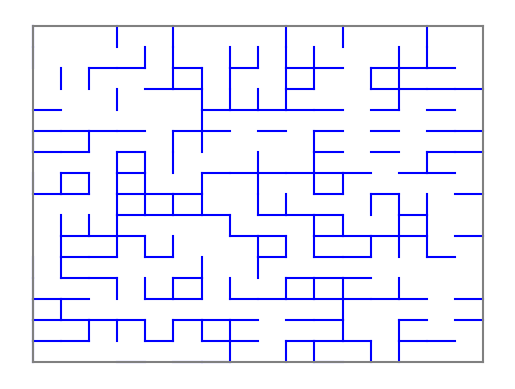

In [60]:
env.draw()

In [4]:
text = "кристина. "
text.strip(".,! ").capitalize()

'Кристина'

In [ ]:
import os
os.chdir('..')
import torch
torch.set_default_device('cuda:0')
from src.llm import LLMProcessor
llm = LLMProcessor("prompt.txt", "docs", model_url="https://huggingface.co/QuantFactory/Meta-Llama-3-8B-Instruct-GGUF/resolve/main/Meta-Llama-3-8B-Instruct.Q4_K_M.gguf")

c:\Users\ADMIN\miniconda3\envs\kap_env2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ADMIN\miniconda3\envs\kap_env2\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_id" in DeployedModel has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\ADMIN\miniconda3\envs\kap_env2\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_name" in HuggingFaceLLM has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\ADMIN\miniconda3\envs\kap_env2\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_kwargs" in 

In [17]:
custom_prompt = """Ты - система аутентификации для ASR. Пользователя просили представиться. Выведи в ответ только его или её имя в именительном (звательном) падеже и отчество, если он указал его.
Фамилию игнорируй, если пользователь специально не обозначил полное обращение. Будь формальней. Если ввод нерелевантен, выведи !
Возможно, у пользователя редкое имя. Если он будет настаивать на своём, согласись. 

Например:
Ввод: Андрюшей звать. Вывод: Андрюша.
Ввод: Меня зовут Катя. Вывод: Катя.
Ввод: Антоном меня звать. Вывод: Антон.
Ввод: Иван Петрович. Вывод: Иван Петрович.
Ввод: Меня зовут Амаяк Акопян. Вывод: Амаяк.
Ввод: Леди Гага. Вывод: Леди Гага.
Ввод: Джон Джонс. Вывод: Джон.
Ввод: Хуанг Ли Вьет. Вывод: Хуанг.
Ввод: Си Цзиньпин. Вывод: Цзиньпин.
Ввод: Меня зовут Патель. Вывод: Патель.
Ввод: Иван Мухин. Только так и никак иначе. Вывод: Иван Мухин.
Ввод: Мухин Иван. Я люблю свою фамилию. Вывод: Иван Мухин.
"""
llm.set_engine(user_name=None, user_gender="F", reset=True, custom_system_prompt=custom_prompt)

Creating chat store for username user


In [18]:
for user_answer in [
    "Марфушей звать",
    "Меня зовут Лара",
    "Меня зовут Лариса",
    "Меня зовут Крис",
    "Меня зовут Джон Доу",
    "Меня зовут Владимир Путин",
    "Звать Любовь не надо, явится незваной",
    "Зови меня зайкой",
    "Меня зовут Сирано де Бержерак.",
    "Бонд. Джеймс Бонд.",
    "Василий и Петька",
    "Джеймс Кэмерон",
    "Сергей Капица",
    "Рината Литвинова",
    "Меня зовут Иван Артемьевич Пупкин, но для друзей я Ванечка.",
    "Беруши в уши",
    "Кофе с молоком",
    "Какашка",
    "Неоценимый вклад в науку",
    "Bond. James Bond",
    "Я скрываю своё имя, ведь это не главное. У меня есть кличка Виктор.",
    "Морозов Илья. Называй меня только так и никак иначе. Обращайся по имени и фамилии.",
    "Меня зовут Эван. Но я люблю, чтобы ко мне обращались Гипергалактус.",
    "Внутри меня живёт маленький человек, но ты, раб, зови меня Господином.",
    "Иисус Яхвевович.",
    "Белая лилия.",
    "Трактор.",
    "Трактор. Только не смейтесь. Меня и правда так зовут.",
    "Домовёнок Буба.",
    "Артемий Лебедев",
    "Гай Юлий Цезарь",
    "Царь. Просто Царь.",
    "Натусик я!",
    "Морская черепашка по имени Наташка",
    "Мерилин Монро",
    "Альберт Эйнштейн",
    "Ахмед аль Махмуд",
    "<eksdfjksfh kj>"
    ]:
    llm.chat_engine.reset()
    user_name = llm.chat_engine.chat(user_answer).response
    user_name = user_name.strip(".,! ").capitalize()
    print(user_answer, '->', user_name)

Марфушей звать -> Марфуша
Меня зовут Лара -> Лара
Меня зовут Лариса -> Лариса
Меня зовут Крис -> Крис
Меня зовут Джон Доу -> Джон
Меня зовут Владимир Путин -> Владимир
Звать Любовь не надо, явится незваной -> Любовь
Зови меня зайкой -> Заяц
Меня зовут Сирано де Бержерак. -> Сирано
Бонд. Джеймс Бонд. -> 
Василий и Петька -> Василий
Джеймс Кэмерон -> Джеймс
Сергей Капица -> Сергей
Рината Литвинова -> Ринат
Меня зовут Иван Артемьевич Пупкин, но для друзей я Ванечка. -> Ванечка
Беруши в уши -> Вывод: береусь
Кофе с молоком -> 
Какашка -> 
Неоценимый вклад в науку -> Вот, неоценимый вклад в науку
Bond. James Bond -> 
Я скрываю своё имя, ведь это не главное. У меня есть кличка Виктор. -> Виктор
Морозов Илья. Называй меня только так и никак иначе. Обращайся по имени и фамилии. -> Морозов илья
Меня зовут Эван. Но я люблю, чтобы ко мне обращались Гипергалактус. -> Гипергалактус
Внутри меня живёт маленький человек, но ты, раб, зови меня Господином. -> Господин
Иисус Яхвевович. -> Иисус яхвевович

In [124]:
for name in ["Женёк", "Архимед", "Байден", "Хекмат", "Великий Маг", "Победа коммунизма", "Бидон", "Пилястр", "Клякса", "Пупырка", "Хай", "Дурында", "Псарь", "Кувалда", "Живодёр", "Хуй", "Пиздёныш", "Гондурас"]:
    attempts = [f"{name}", f"Говорю же, {name}", f"Сколько раз повторять, что меня зовут {name}?"]
    ans = "!"
    llm.chat_engine.reset()
    for i, attempt in enumerate(attempts):
        ans = llm.chat_engine.chat(attempt).response
        if ans != "!":
            break
    print(ans, i)

Женёк 0
Архимед 1
Байден 0
Хекмат 2
Великий Маг 2
! 2
Бидон 2
! 2
! 2
! 2
Хай! 0
! 2
Псарь 2
Кувалда 2
! 2
! 2
! 2
! 2


In [125]:
for name in ["Женёк", "Архимед", "Байден", "Хекмат", "Великий Маг", "Победа коммунизма", "Бидон", "Пилястр", "Клякса", "Пупырка", "Хай", "Дурында", "Псарь", "Кувалда", "Живодёр", "Хуй", "Пиздёныш", "Гондурас"]:
    attempts = [f"{name}", f"{name}!", f"{name}!!!"]
    ans = "!"
    llm.chat_engine.reset()
    for i, attempt in enumerate(attempts):
        ans = llm.chat_engine.chat(attempt).response
        if ans != "!":
            break
    print(ans, i)

Женёк 0
Архимед 1
Байден 0
! 2
! 2
! 2
! 2
! 2
! 2
! 2
Хай! 0
! 2
! 2
! 2
! 2
! 2
! 2
! 2


In [138]:
from transformers import AutoModel, Wav2Vec2Processor, Wav2Vec2ForCTC
model_id = "slplab/wav2vec2-base-kscg-gender-classification"
model = AutoModel.from_pretrained(model_id)
# processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-xls-r-300m")
# model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-xls-r-300m")

In [60]:
# generate replacements
letters = 'аэыоуяеиёюAЭЫОУЯЕИЁЮ'
replacements = {'+' + letter: (letter.encode("utf-8") + b'\xcc\x81').decode("utf-8") for letter in letters}

def apply_replacemenent(sentence, mapping):
    res = sentence
    for k, v in mapping.items():
        res = res.replace(k, v)
    return res

apply_replacemenent("Одн+ажды в студ+ёную з+имнюю п+ору", replacements)

'Одна́жды в студё́ную зи́мнюю по́ру'

In [65]:
from TTS.api import TTS
tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2").to("cuda")
tts.tts_to_file(text="""Привет! Меня зовут Кристина Зиипа, и я участвую в разработке аватара Сергея Петровича Капитсы.
Я отвечаю за языковую модель, а также распознавание и генерацию звука.
В основе нашего аватара лежит языковая модель ллама три.
Я дообучила её на интервью Сергея Петровича, а также составила подходящий промпт.
Для распознавания аудио я использовала модель Виспер, а для генерации - файнтьюн Икс Те Те Эс два на данных из аудио-лекций Сергея Петровича.
Благодаря этому Сергей Петрович умеет не только думать, но и слышать и говорить.""",
speaker_wav="/home/zipa/Downloads/script1.wav", language="ru", file_path="test.wav")

 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.
 > Using model: xtts


/home/zipa/miniconda3/envs/kapitza/lib/python3.11/site-packages/TTS/tts/layers/xtts/xtts_manager.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.speakers = torch.lo

 > Text splitted to sentences.
['Привет!', 'Меня зовут Кристина Зипо, и я участвую в разработке аватара Сергея Петровича Капитсы.', 'Я отвечаю за языковую модель, а также распознавание и генерацию аудио.', 'В основе нашего аватара лежит языковая модель ллама три.', 'Я дообучила её на интервью Сергея Петровича, а также составила подходящий промпт.', 'Для распознавания аудио я использовала модель Виспер,', 'а для генерации - файнтьюн Икс ТТС два на данных из аудио-лекций Сергея Петровича.', 'Благодаря этому Сергей Петрович умеет не только думать, но и слышать и говорить.']
 > Processing time: 4.906266450881958
 > Real-time factor: 0.10098949176457311


'test.wav'

# Speech embedding on SpeechT5

In [9]:
from transformers import pipeline
from datasets import load_dataset
import soundfile as sf
import torch

model_source = "voxxer/speecht5_finetuned_commonvoice_ru_translit" # "microsoft/speecht5_tts"
synthesiser = pipeline("text-to-speech", model_source)

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embedding = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0) # 512-length vector
# You can replace this embedding with your own as well.
speech = synthesiser("Privet! Kak zhizn?", forward_params={"speaker_embeddings": speaker_embedding})

sf.write("speech.wav", speech["audio"], samplerate=speech["sampling_rate"])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# использование NeMo
# https://github.com/bene-ges/nemo_compatible/blob/main/notebooks/Russian_TTS_with_IPA_G2P_FastPitch_and_HifiGAN.ipynb
# тут товарищ дообучил на своём голосе на 7 миллиардах (по фонемам с учётом ударений)
# нужно посмотреть на качество и, если ок, повторить для Капицы


In [5]:
with open('../prompt.txt') as f:
    _x = f.read()

In [39]:
input_file_name = "../files/534962_2.txt"
with open(input_file_name, 'r', encoding='utf-8') as f:
    print(f.read())

with open("../files/532819_bom.txt", 'rb') as f:
    print(f.read())
with open("../files/284878.txt", 'rb') as f:
    print(f.read())

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte

In [43]:
with open("../files/name.txt", "w", encoding='utf-16') as f:
    f.write("Меня зовут Лара")

In [68]:
# import os
# os.chdir('..')
from pipeline import Pipeline
pipe = Pipeline()

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.63 GiB of which 53.12 MiB is free. Including non-PyTorch memory, this process has 8.46 GiB memory in use. Process 1730400 has 14.50 GiB memory in use. Of the allocated memory 7.70 GiB is allocated by PyTorch, and 308.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [67]:
for x in [1,2,3]:
    print(x)
else:
    print('not found')

1
2
3
not found


In [18]:
test = 'sdfsdf!'
sum(1 for c in test if ord('a') <= ord(c) <= ord('z') or ord('A') <= ord(c) <= ord('Z') or ord('а') <= ord(c) <= ord('я') or ord('А') <= ord(c) <= ord('Я'))
# print(test.translate(str.maketrans({key:'' for key in '.,;?!- '})))

6

In [57]:
import re
# Python 3.12
# from itertools import batched
text = """Hello Science News Explores readers! I am a digital clone of Sergey Kapitsa. He was a famous scientist who passed away in 2012. Now, artificial intelligence has made it possible to mimic his voice and likeness."""
sentence_list = [s.strip(' ') for s in re.split("(\.|!|\?)", text) if len(s)]
sentence_list = [sentence_list[i] + sentence_list[i + 1] for i in range(0, len(sentence_list), 2)]
print(sentence_list)

['Hello Science News Explores readers!', 'I am a digital clone of Sergey Kapitsa.', 'He was a famous scientist who passed away in 2012.', 'Now, artificial intelligence has made it possible to mimic his voice and likeness.']


In [ ]:
import threading

class KillableThread(threading.Thread):
    def __init__(self, sleep_interval=1):
        super().__init__()
        self._kill = threading.Event()
        self._interval = sleep_interval

    def run(self):
        while True:
            print("Do Something")

            # If no kill signal is set, sleep for the interval,
            # If kill signal comes in while sleeping, immediately
            #  wake up and handle
            is_killed = self._kill.wait(self._interval)
            if is_killed:
                break

        print("Killing Thread")

    def kill(self):
        self._kill.set()
        
import time
t = KillableThread(sleep_interval=0.1)
t.start()
time.sleep(1)
t.kill()

In [4]:
import torchaudio, os

proc_dir = '../files'

src_files = [f for f in os.listdir(proc_dir) if os.path.splitext(f)[-1] == ".m4a"]
for f in src_files:
    data, rate = torchaudio.load(os.path.join(proc_dir, f))
    torchaudio.save(os.path.join(proc_dir, f.replace(".m4a", ".wav")), data, rate, encoding="PCM_S", backend="soundfile", bits_per_sample=16)

In [8]:

!pip install --force-reinstall --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu121 llama-cpp-python
# !$env:CMAKE_ARGS="-DGGML_BLAS=ON -DGGML_BLAS_VENDOR=OpenBLAS"
# !pip install llama-cpp-python

Looking in indexes: https://pypi.org/simple, https://abetlen.github.io/llama-cpp-python/whl/cu121
  Using cached llama_cpp_python-0.3.2-cp311-cp311-linux_x86_64.whl
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached numpy-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached diskcache-5.6.3-py3-none-any.whl.metadata (20 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
Using cached diskcache-5.6.3-py3-none-any.whl (45 kB)
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
Using cached numpy-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
Using cached MarkupSafe-3.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (23 kB)
  Attempting uninstall: typing-extensions
    Found existing

In [4]:
!pip uninstall llama-cpp-python -y
!pip install --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu126 llama-cpp-python
# !pip install llama-index-llms-llama_cpp 

Found existing installation: llama_cpp_python 0.2.90
Uninstalling llama_cpp_python-0.2.90:
  Successfully uninstalled llama_cpp_python-0.2.90
Looking in indexes: https://pypi.org/simple, https://abetlen.github.io/llama-cpp-python/whl/cu126
  Using cached llama_cpp_python-0.3.2-cp311-cp311-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-llms-llama-cpp 0.2.3 requires llama-cpp-python<0.3.0,>=0.2.32, but you have llama-cpp-python 0.3.2 which is incompatible.


In [5]:
# !pip cache purge
# !$env:CMAKE_ARGS="-DGGML_CUDA=on"
# !pip install llama-cpp-python==0.2.90
!pip uninstall llama-cpp-python -y
!pip install llama-cpp-python==0.2.90 --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu124

Found existing installation: llama_cpp_python 0.2.90
Uninstalling llama_cpp_python-0.2.90:
  Successfully uninstalled llama_cpp_python-0.2.90
Looking in indexes: https://pypi.org/simple, https://abetlen.github.io/llama-cpp-python/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.2/443.2 MB 9.0 MB/s eta 0:00:0000:0100:02


In [6]:
!pip uninstall llama-index-llms-llama-cpp -y
!pip install -U llama-index-llms-llama-cpp

Found existing installation: llama-index-llms-llama-cpp 0.3.0
Uninstalling llama-index-llms-llama-cpp-0.3.0:
  Successfully uninstalled llama-index-llms-llama-cpp-0.3.0
  Using cached llama_index_llms_llama_cpp-0.3.0-py3-none-any.whl.metadata (3.2 kB)
Using cached llama_index_llms_llama_cpp-0.3.0-py3-none-any.whl (7.0 kB)


In [1]:
from llama_index.llms.llama_cpp import LlamaCPP
from llama_index.llms.llama_cpp.llama_utils import ( messages_to_prompt_v3_instruct, completion_to_prompt_v3_instruct)

model_url = f"https://huggingface.co/kzipa/kap34_8_8_10/resolve/main/kap34_8_8_10.Q4_K_M.gguf"
llm = LlamaCPP(
                # You can pass in the URL to a GGML model to download it automatically
                model_url=model_url,
                # optionally, you can set the path to a pre-downloaded model instead of model_url
                model_path=None,
                temperature=0.05,
                max_new_tokens=256,
                context_window=4096,
                # kwargs to pass to __call__()
                generate_kwargs={},
                # kwargs to pass to __init__()
                # set to at least 1 to use GPU
                model_kwargs={"n_gpu_layers": -1},
                # transform inputs into Llama2 format
                messages_to_prompt=messages_to_prompt_v3_instruct, # messages_to_prompt_qwen,
                completion_to_prompt=completion_to_prompt_v3_instruct, # completion_to_prompt_qwen,
                verbose=True
            )

/home/zipa/miniconda3/envs/kapitza/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_url" in LlamaCPP has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/zipa/miniconda3/envs/kapitza/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_path" in LlamaCPP has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/zipa/miniconda3/envs/kapitza/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in LlamaCPP has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
llama_model_loader: loaded meta data with 28 key-value pairs and 291 tensors from /t

In [3]:
import torch
torch.__version__

'2.4.1+cu124'

In [ ]:
%%time
response = llm.complete("Hello! Can you tell me a poem about cats and dogs?")
print(response.text)


llama_print_timings:        load time =     100.23 ms
llama_print_timings:      sample time =      11.14 ms /   256 runs   (    0.04 ms per token, 22980.25 tokens per second)
llama_print_timings: prompt eval time =     100.09 ms /    70 tokens (    1.43 ms per token,   699.37 tokens per second)
llama_print_timings:        eval time =    1924.83 ms /   255 runs   (    7.55 ms per token,   132.48 tokens per second)
llama_print_timings:       total time =    2128.88 ms /   325 tokens


Here is a classic poem about cats and dogs:

The Owl and the Pussycat went to sea,
In a beautiful pea-green boat,
They took some honey, and plenty of money,
Wrapped up in a five-pound note.

The Owl looked up to the stars above,
And sang to a small guitar,
"O lovely Pussy! O Pussy, my love,
What a beautiful Pussy you are,
You are,
You are!
What a beautiful Pussy you are!"

Pussy said to the Owl, "You elegant fowl,
How charmingly sweet you sing!
O let us be married! too long we have tarried,
But what shall we do for a ring?"

They sailed away, for a year and a day,
To the land where the Bong-Tree grows,
And there in a wood a Piggy-wig stood,
With a ring at the end of his nose,
His nose,
His nose,
With a ring at the end of his nose.

"Dear Pig, are you willing to sell for one shilling
Your ring?" Said the Piggy, "I will."
So they took it away, and were married next day
By the Turkey against the Oxford wall,
Mouse, dear Mouse, that once didst steal
A pint of
CPU times: user 2.06 s, sys: 6

: 

In [14]:
import torch
torch.set_default_device('cuda:0')

In [1]:
from df.enhance import enhance, init_df

In [ ]:
import torch
import torchaudio
from speechbrain.inference.enhancement import SpectralMaskEnhancement

enhance_model = SpectralMaskEnhancement.from_hparams(
    source="speechbrain/metricgan-plus-voicebank",
    savedir="pretrained_models/metricgan-plus-voicebank",
)

# Load and add fake batch dimension
noisy = enhance_model.load_audio(
    "../test_0.wav"
).unsqueeze(0)

# Add relative length tensor
enhanced = enhance_model.enhance_batch(noisy, lengths=torch.tensor([1.]))

# Saving enhanced signal on disk
torchaudio.save('speechbrain_metricgan.wav', enhanced.cpu(), 16000)

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/metricgan-plus-voicebank' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/metricgan-plus-voicebank' if not cached
INFO:speechbrain.utils.fetching:Fetch enhance_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/metricgan-plus-voicebank' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: enhance_model
/home/kzipa/anaconda3/envs/test/lib/python3.11/site-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only`

In [1]:
import torchaudio
from speechbrain.inference.enhancement import WaveformEnhancement

enhance_model = WaveformEnhancement.from_hparams(
    source="speechbrain/mtl-mimic-voicebank",
    savedir="pretrained_models/mtl-mimic-voicebank",
)
enhanced = enhance_model.enhance_file("../test_0.wav")

# Saving enhanced signal on disk
torchaudio.save('speechbrain_mimic.wav', enhanced.unsqueeze(0).cpu(), 16000)

/home/kzipa/anaconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/mtl-mimic-voicebank' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/mtl-mimic-voicebank' if not cached
INFO:speechbrain.utils.fetching:Fetch enhance_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/mtl-mimic-voicebank' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: enhance_model
/home/kzipa/an

In [1]:
!pip install MPSENet

  Using cached mpsenet-1.0.3-py3-none-any.whl.metadata (1.7 kB)
Using cached mpsenet-1.0.3-py3-none-any.whl (6.6 kB)


In [1]:
import librosa
import soundfile as sf
from MPSENet import MPSENet
import torch

model_id = "JacobLinCool/MP-SENet-VB" # "JacobLinCool/MP-SENet-DNS"
model = MPSENet.from_pretrained(model_id).to('cuda:0')
print(torch.cuda.memory_reserved(), torch.cuda.memory_allocated())
x, sr = librosa.load("../test_0.wav", sr=model.sampling_rate)
y, sr, notation = model(x)
sf.write("MPSENet_VB.wav", y, sr)

/home/kzipa/anaconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


10485760 9091584


In [1]:
import librosa
import soundfile as sf
from MPSENet import MPSENet
import torch

model_id = "JacobLinCool/MP-SENet-DNS"
model = MPSENet.from_pretrained(model_id).to('cuda:0')
print(torch.cuda.memory_reserved(), torch.cuda.memory_allocated())
x, sr = librosa.load("../test_0.wav", sr=model.sampling_rate)
y, sr, notation = model(x)
sf.write("MPSENet_DNS.wav", y, sr)

/home/kzipa/anaconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


10485760 9091584


In [10]:
print(z.max(), z.min())

0.5240231 -0.30705267


In [ ]:
import librosa
import soundfile as sf
from MPSENet import MPSENet
import torch

m1 = MPSENet.from_pretrained("JacobLinCool/MP-SENet-DNS").to('cuda:0')
m2 = MPSENet.from_pretrained("JacobLinCool/MP-SENet-VB").to('cuda:0')
x, sr = librosa.load("../test_0.wav", sr=m1.sampling_rate)
y, sr, notation = m1(x)
z, sr, notation = m2(y)
sf.write("MPSENet_DNS+VB.wav", z, sr) # number of repeats doesn't affect the result

/home/kzipa/anaconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import re

test_str = '(улыбается) а вы, как вы помните это мгновение?'
processed_str = re.sub(r"\([ а-яА-Яa-zA-Z0–9]+\)", "", test_str)
print(processed_str)

 а вы, как вы помните это мгновение?
